In [1]:
import math
from scipy.stats import norm, skewnorm, cauchy, lognorm
import logging
import json
import sys
import os
from numpy import nan

import xlwt
import xlsxwriter
from tempfile import TemporaryFile
import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

#%matplotlib inline
clr_palette = ([sns.color_palette("YlGn", 15)[10],sns.cubehelix_palette(8)[6]])

pydice_folder = os.path.dirname(os.getcwd()) + '\\1_Model'
sys.path.append(pydice_folder)

from SALib.analyze import sobol

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments, LHS, SOBOL, MORRIS
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import feature_scoring
# from ema_workbench.analysis.scenario_discovery_util import CLASSIFICATION, REGRESSION

from ema_workbench.util import ema_logging
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, ScalarOutcome, ArrayOutcome, 
                           Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)

from PyRICE_V9 import PyRICE

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


In [2]:
RICE_POP_gr = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Pop_gr")
income_shares = pd.read_excel("Distribution of income.xlsx", sheet_name="income share")
country_groupings = pd.read_excel("Distribution of income.xlsx", sheet_name="country_grouping")

country_groupings_RICE = pd.read_excel('ssp uncertainty calculation.xlsx',sheet_name = 'Counry groupings RICE')
country_groupings_RICE = country_groupings_RICE.iloc[:,0:5] 

regions_list = ["US", "OECD-Europe","Japan","Russia","Non-Russia Eurasia","China","India","Middle East","Africa",
    "Latin America","OHI","Other non-OECD Asia"]

"""
####################### Population PARAMETERS and set up dataframe format #######################
"""
#get population growth rates for each region
a=[]
for i in range(31):  
    if i == 0:
        a.append("region")
    k = 2005 + 10 * i
    k = str(k)
    a.append(k)    

region_pop_gr = RICE_POP_gr.iloc[10:22,3:35]
region_pop_gr.columns =  a
region_pop_gr = region_pop_gr.set_index('region') 

In [3]:
model = PyRICE(model_specification="Validation_1",welfare_function = "utilitarian")
results = model()

In [6]:
#Get results from RICE2010 optimal run
validation_series = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Validation series")

sr_opt_series = validation_series.iloc[21:33,3:34]
sr_opt_series.index = region_pop_gr.index
sr_opt_series.columns = region_pop_gr.columns

miu_opt_series = validation_series.iloc[6:18,3:34]
miu_opt_series.index = region_pop_gr.index
miu_opt_series.columns = region_pop_gr.columns

utility = validation_series.iloc[48:49,3:34]
utility.columns = region_pop_gr.columns

damages = validation_series.iloc[51:52,3:34]
damages.columns = region_pop_gr.columns

temperature = validation_series.iloc[54:55,3:34]
temperature.columns = region_pop_gr.columns

emissions = validation_series.iloc[57:58,3:34]
emissions.columns = region_pop_gr.columns

total_output = validation_series.iloc[60:61,3:34]
total_output.columns = region_pop_gr.columns

In [7]:
#output PyRICE
output_Y = model.Y
output_E = model.E
output_U = model.per_util_ww
output_D = model.damages
output_T = model.temp_atm

output_Y = pd.DataFrame(data=output_Y,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_Y = output_Y.transpose()
output_Y.loc[:,'Global PyRICE'] = output_Y.sum(axis=1)

output_E = pd.DataFrame(data=output_E,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_E = output_E.transpose()
output_E.loc[:,'Global PyRICE'] = output_E.sum(axis=1)

output_U = pd.DataFrame(data=output_U,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_U = output_U.transpose()
output_U.loc[:,'Global PyRICE'] = output_U.sum(axis=1)

output_D = pd.DataFrame(data=output_D,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_D = output_D.transpose()
output_D.loc[:,'Global PyRICE'] = output_D.sum(axis=1)

output_T = pd.DataFrame(data=output_T)
output_T.columns = ["Global PyRICE"]
output_T.index = output_D.index

output_U['Global RICE'] = utility.transpose()
output_Y['Global RICE'] = total_output.transpose()
output_E['Global RICE'] = emissions.transpose()
output_D['Global RICE'] = damages.transpose()
output_T['Global RICE'] = temperature.transpose()

output_T = output_T[['Global RICE','Global PyRICE']]
output_Y = output_Y[['Global RICE','Global PyRICE']]
output_E = output_E[['Global RICE','Global PyRICE']]
output_D = output_D[['Global RICE','Global PyRICE']]
output_U = output_U[['Global RICE','Global PyRICE']]

output_PyRICE = [output_Y,output_E,output_U,output_D,output_T]
plot_df = pd.concat(output_PyRICE, axis=1)

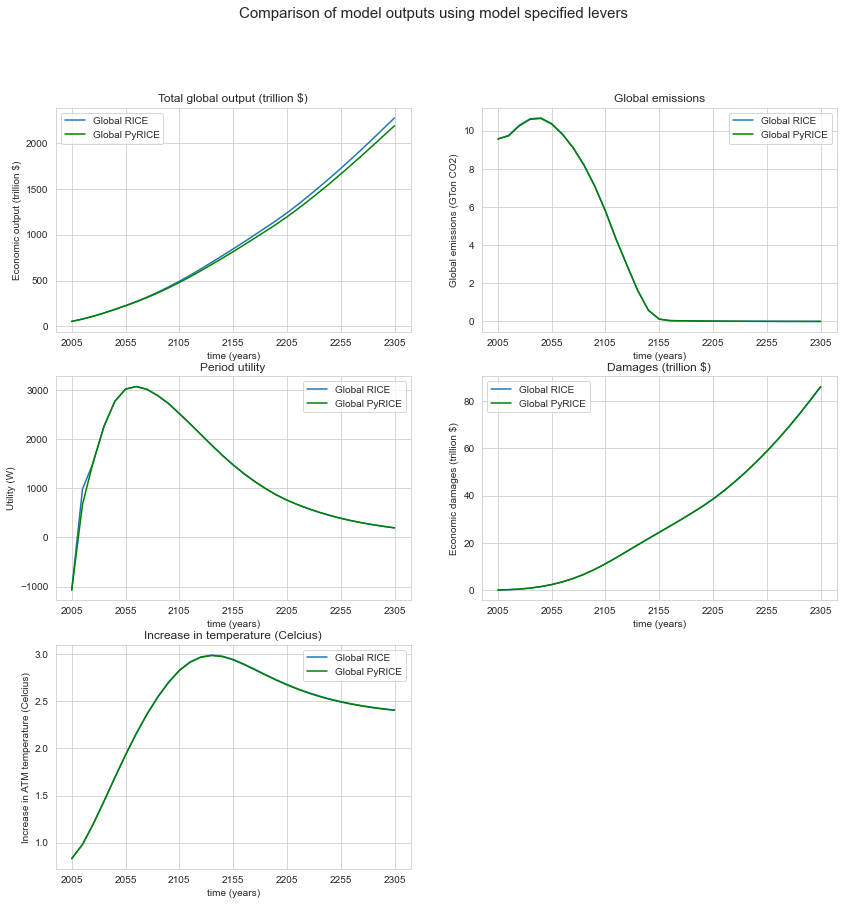

In [8]:
#set up graph with subplots to compare with original RICE output
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))
fig.delaxes(axes[2][1])

fig.suptitle("Comparison of model outputs using model specified levers", fontsize=15)

plot_df.iloc[:,0].plot(ax=axes[0,0]); axes[0,0].set_title('Total global output (trillion $)'),
axes[0,0].set(xlabel='time (years)', ylabel='Economic output (trillion $)'), axes[0,0].legend()
plot_df.iloc[:,1].plot(ax=axes[0,0],secondary_y=False, style='g'); axes[0,0].legend()


plot_df.iloc[:,2].plot(ax=axes[0,1]); axes[0,1].set_title('Global emissions')
axes[0,1].set(xlabel='time (years)', ylabel='Global emissions (GTon CO2)'), axes[0,1].legend()
plot_df.iloc[:,3].plot(ax=axes[0,1],secondary_y=False, style='g'); axes[0,1].legend()


plot_df.iloc[:,4].plot(ax=axes[1,0]); axes[1,0].set_title('Period utility')
axes[1,0].set(xlabel='time (years)', ylabel='Utility (W)'), axes[1,0].legend()
plot_df.iloc[:,5].plot(ax=axes[1,0],secondary_y=False, style='g'); axes[1,0].legend()


plot_df.iloc[:,6].plot(ax=axes[1,1]); axes[1,1].set_title('Damages (trillion $)')
axes[1,1].set(xlabel='time (years)', ylabel='Economic damages (trillion $)'), axes[1,1].legend()
plot_df.iloc[:,7].plot(ax=axes[1,1],secondary_y=False, style='g'); axes[1,1].legend()

plot_df.iloc[:,8].plot(ax=axes[2,0]); axes[2,0].set_title('Increase in temperature (Celcius)')
axes[2,0].set(xlabel='time (years)', ylabel='Increase in ATM temperature (Celcius)'),axes[2,0].legend()
plot_df.iloc[:,9].plot(ax=axes[2,0],secondary_y=False, style='g'); axes[2,0].legend()
